In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
import time
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K

In [2]:
import os
import shutil

# Paths to folders
train_dir = "train"
images_dir = "JPEGImages"
annotation_dir = "Annotations"

# Create output folders if they do not exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(annotation_dir, exist_ok=True)

# Loop over all files in the train directory
for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)
    
    # Check if it's a file (not a subfolder)
    if os.path.isfile(file_path):
        # If file ends with .jpg => move to images_dir
        if filename.lower().endswith(".jpg"):
            shutil.move(file_path, os.path.join(images_dir, filename))
        
        # If file ends with .xml => move to annotation_dir
        elif filename.lower().endswith(".xml"):
            shutil.move(file_path, os.path.join(annotation_dir, filename))

print("Files have been successfully moved!")

Files have been successfully moved!


In [3]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation('Annotations/','JPEGImages/', labels=[])
print("N train = {}".format(len(train_image)))
print(f"Seen labels = {seen_train_labels}")

N train = 2376
Seen labels = {'objects': 2350, '0': 26}


In [4]:
train_image[0]

{'object': [{'name': 'objects',
   'xmin': 104,
   'xmax': 154,
   'ymin': 218,
   'ymax': 237}],
 'filename': 'JPEGImages/1001_jpg.rf.dfc0798279d416e17e5b66b7732b0d02.jpg',
 'width': 300,
 'height': 300}

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_bboxes(image_data):
    img_path = image_data['filename']
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
        
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    for obj in image_data['object']:
        xmin, ymin = obj['xmin'], obj['ymin']
        width = obj['xmax'] - obj['xmin']
        height = obj['ymax'] - obj['ymin']
        label = obj['name']

        # Draw bounding box
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Draw label
        ax.text(xmin, ymin - 5, label, fontsize=9, color='white',
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import cv2
import copy

def flip_image_and_annotation(image_data, flip_type='horizontal', output_dir='JPEGImages_flipped'):
    """
    Flips the image and corresponding bounding boxes, and saves the flipped image.

    Args:
        image_data (dict): Annotation info for one image.
        flip_type (str): 'horizontal' or 'vertical'
        output_dir (str): Directory to save the flipped images.

    Returns:
        dict: New image_data with flipped bounding boxes and updated filename.
    """
    flipped = copy.deepcopy(image_data)

    # Load original image
    img_path = image_data['filename']
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    height, width = image.shape[:2]

    # Perform flip
    if flip_type == 'horizontal':
        flipped_image = cv2.flip(image, 1)
    elif flip_type == 'vertical':
        flipped_image = cv2.flip(image, 0)
    else:
        raise ValueError("flip_type must be 'horizontal' or 'vertical'")

    # Update bounding boxes
    for obj in flipped['object']:
        xmin, xmax = obj['xmin'], obj['xmax']
        ymin, ymax = obj['ymin'], obj['ymax']
        if flip_type == 'horizontal':
            obj['xmin'] = width - xmax
            obj['xmax'] = width - xmin
        elif flip_type == 'vertical':
            obj['ymin'] = height - ymax
            obj['ymax'] = height - ymin

    # Ensure output folder exists
    os.makedirs(output_dir, exist_ok=True)

    # Create new filename path
    base_filename = os.path.basename(img_path)
    flipped_filename = f"{flip_type}_{base_filename}"
    flipped_path = os.path.join(output_dir, flipped_filename)

    # Save the flipped image
    cv2.imwrite(flipped_path, flipped_image)

    # Update annotation filename
    flipped['filename'] = flipped_path

    return flipped

l = len(train_image)
train_image_flip = []
for i in range(l):
    sample = train_image[i]
    flipped_horizontal = flip_image_and_annotation(sample, flip_type='horizontal')
    train_image_flip.append(flipped_horizontal)
    flipped_vertical = flip_image_and_annotation(sample, flip_type='vertical')
    train_image_flip.append(flipped_vertical)

print(len(train_image),len(train_image_flip))

2376 4752


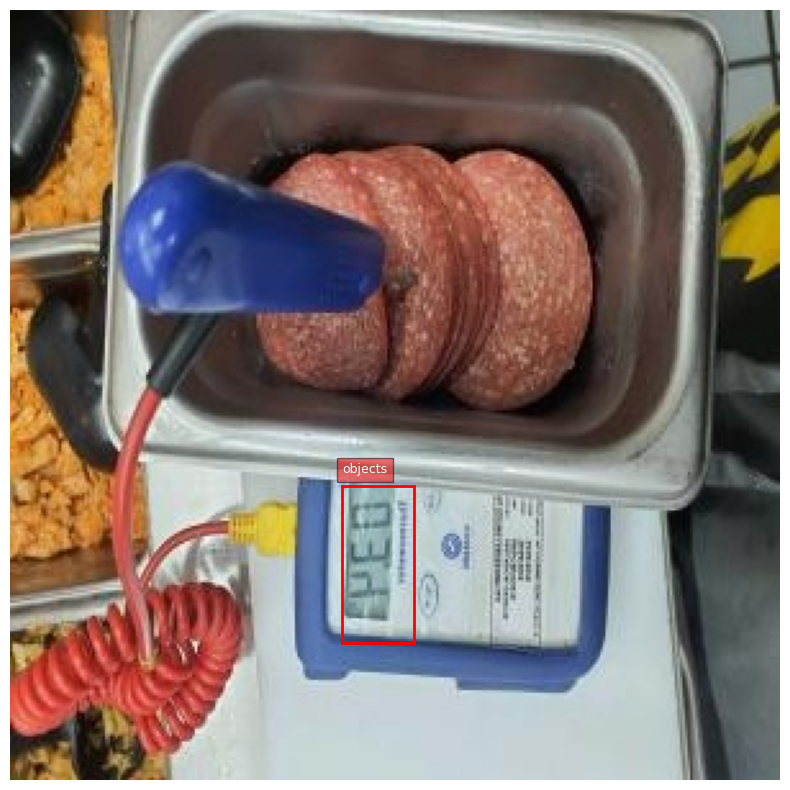

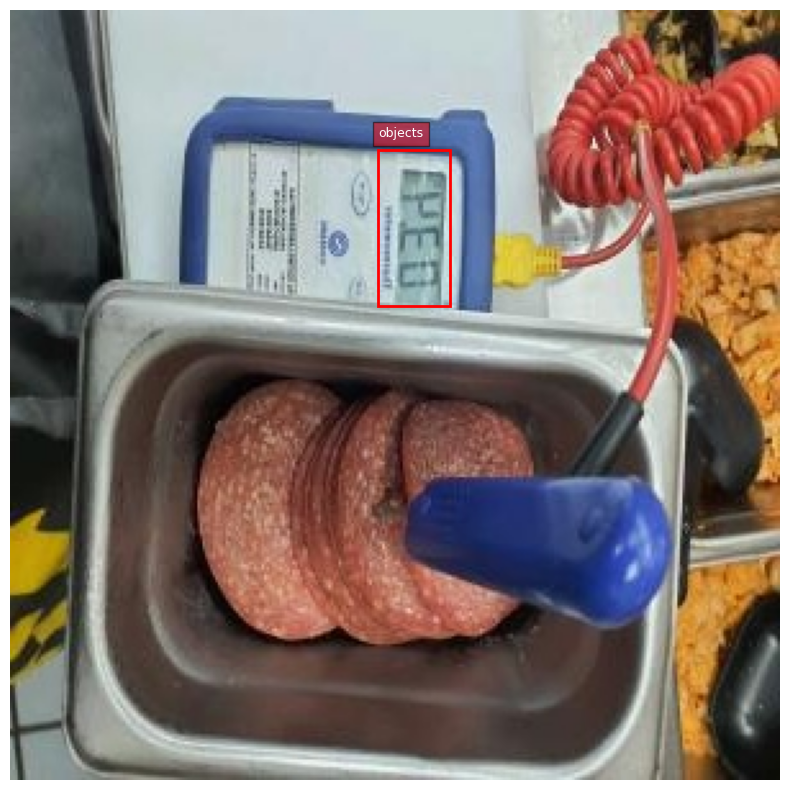

In [7]:
plot_image_with_bboxes(flipped_vertical)
plot_image_with_bboxes(flipped_horizontal)

In [8]:
import os
import cv2
import copy

def rotate_image_and_annotation(image_data, angle, output_dir='JPEGImages_rotated'):
    """
    Rotates the image and bounding boxes by 90, 180, or 270 degrees CCW.

    Args:
        image_data (dict): Annotation info for one image.
        angle (int): Rotation angle in degrees (90, 180, 270 only).
        output_dir (str): Directory to save rotated images.

    Returns:
        dict: New image_data with rotated bounding boxes and updated filename.
    """
    if angle not in [90, 180, 270]:
        raise ValueError("Only 90, 180, 270 degrees supported")

    rotated = copy.deepcopy(image_data)

    # Load original image
    img_path = image_data['filename']
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    height, width = image.shape[:2]

    # Rotate the image using OpenCV
    if angle == 90:
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        rotated_image = cv2.rotate(image, cv2.ROTATE_180)
    elif angle == 270:
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    # Rotate the bounding boxes
    for obj in rotated['object']:
        xmin, xmax = obj['xmin'], obj['xmax']
        ymin, ymax = obj['ymin'], obj['ymax']

        if angle == 90:
            obj['xmin'] = ymin
            obj['xmax'] = ymax
            obj['ymin'] = width - xmax
            obj['ymax'] = width - xmin

        elif angle == 180:
            obj['xmin'] = width - xmax
            obj['xmax'] = width - xmin
            obj['ymin'] = height - ymax
            obj['ymax'] = height - ymin

        elif angle == 270:
            obj['xmin'] = height - ymax
            obj['xmax'] = height - ymin
            obj['ymin'] = xmin
            obj['ymax'] = xmax

    # Swap width/height for 90 and 270 degrees
    if angle in [90, 270]:
        rotated['width'], rotated['height'] = height, width
    else:
        rotated['width'], rotated['height'] = width, height

    # Save image to output directory
    os.makedirs(output_dir, exist_ok=True)
    base_filename = os.path.basename(img_path)
    rotated_filename = f"{angle}_{base_filename}"
    rotated_path = os.path.join(output_dir, rotated_filename)
    cv2.imwrite(rotated_path, rotated_image)

    # Update annotation filename
    rotated['filename'] = rotated_path

    return rotated

l = len(train_image)
train_image_rot = []
for i in range(l):
    sample = train_image[i]
    rot_90 = rotate_image_and_annotation(sample, angle=90)
    train_image_rot.append(rot_90)
    rot_180 = rotate_image_and_annotation(sample, angle=180)
    train_image_rot.append(rot_90)
    rot_270 = rotate_image_and_annotation(sample, angle=270)
    train_image_rot.append(rot_270)

print(len(train_image),len(train_image_rot))

2376 7128


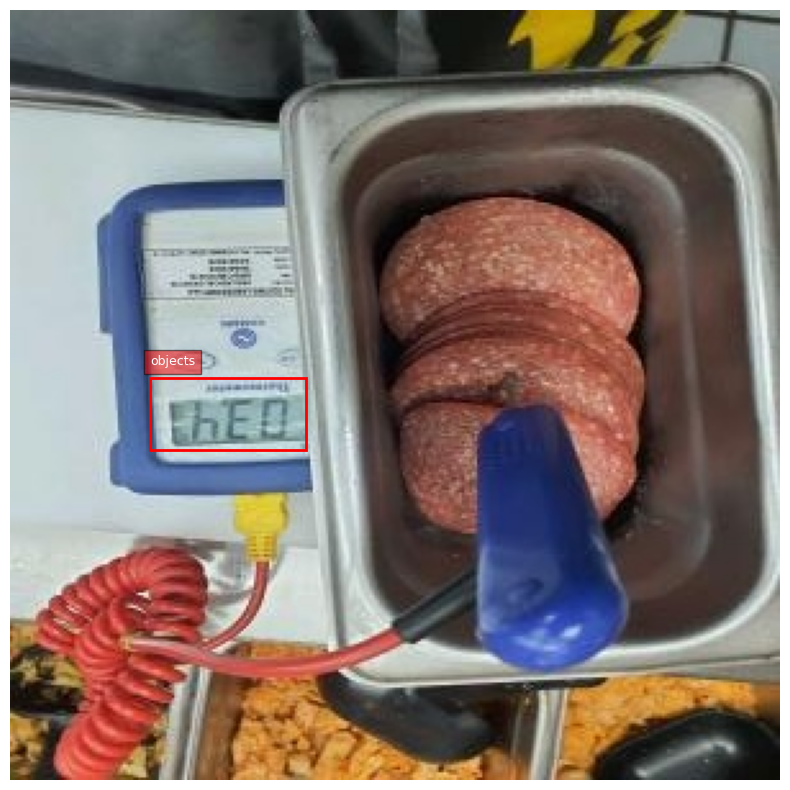

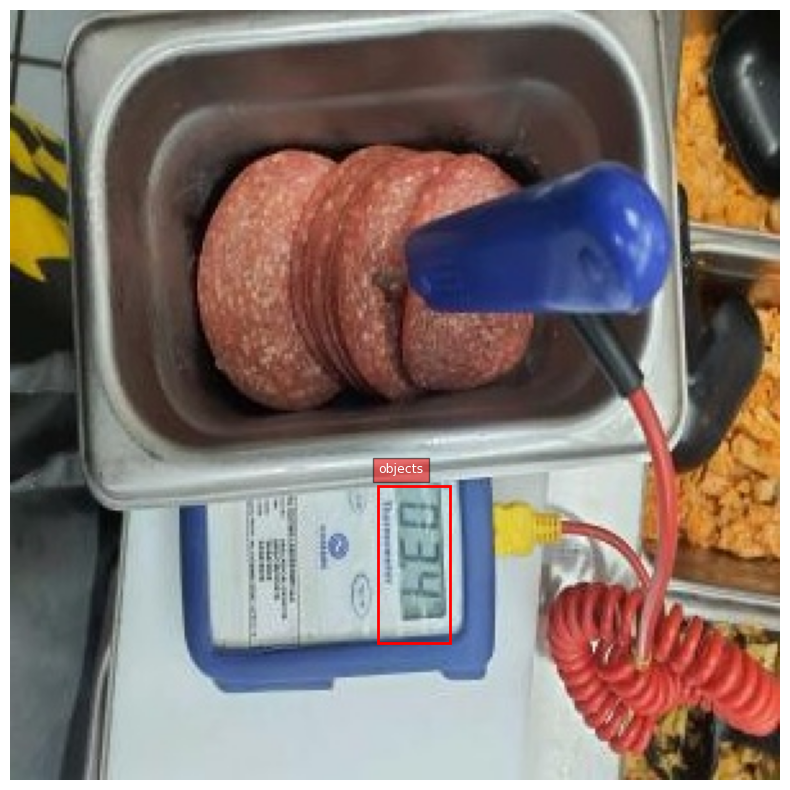

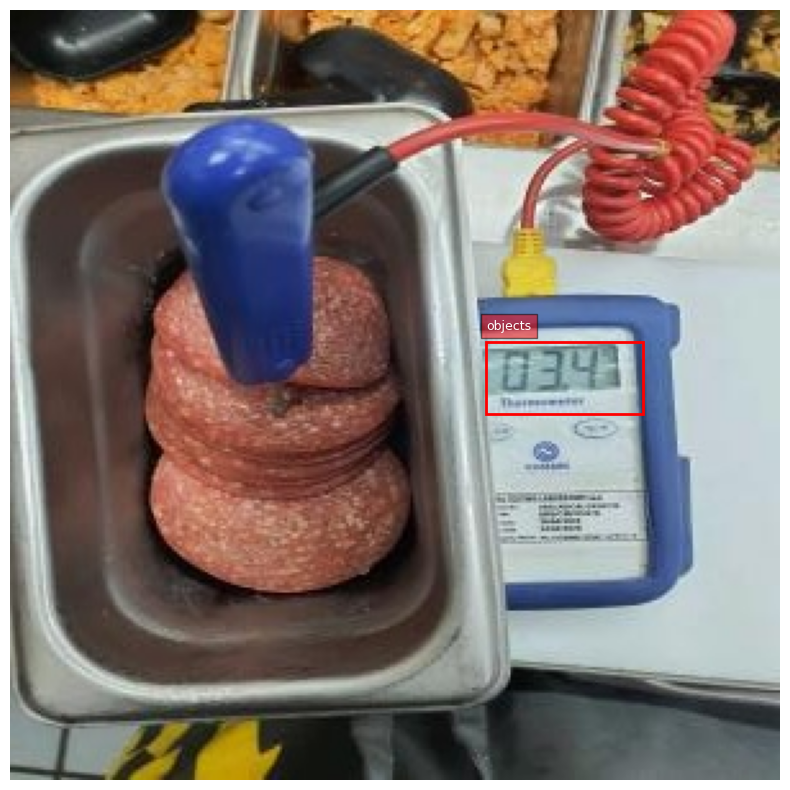

In [9]:
plot_image_with_bboxes(rot_90)
plot_image_with_bboxes(rot_180)
plot_image_with_bboxes(rot_270)

In [10]:
len(train_image),len(train_image+train_image_rot+train_image_flip)

(2376, 14256)

In [11]:
train_image = train_image+train_image_rot+train_image_flip
len(train_image)

14256

In [12]:
train_image[:2]

[{'object': [{'name': 'objects',
    'xmin': 104,
    'xmax': 154,
    'ymin': 218,
    'ymax': 237}],
  'filename': 'JPEGImages/1001_jpg.rf.dfc0798279d416e17e5b66b7732b0d02.jpg',
  'width': 300,
  'height': 300},
 {'object': [{'name': 'objects',
    'xmin': 145,
    'xmax': 197,
    'ymin': 177,
    'ymax': 226}],
  'filename': 'JPEGImages/1003_jpg.rf.9e1dd0b2f20c2c4e8421872a1082338f.jpg',
  'width': 300,
  'height': 300}]

In [13]:
import json 
# File path to save and read the data
file_path = "train_image_annotations.json"

# Save the train_image list to a JSON file
with open(file_path, "w") as f:
    json.dump(train_image, f, indent=4)

# Read the data back from the file
with open(file_path, "r") as f:
    loaded_train_image = json.load(f)